In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

set environment variables
All done


In [4]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [5]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows,\
getValueBySelection
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.utils.labelUtil import repeat_pop_arr, getSuperpopBins
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix
from src.main.settings_model import parse_args, MODEL_CLASS
import test

In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_2_geo')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_2_geo')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_1_data_id_2_geo/') 
dataset_type='valid'

In [7]:
# load the params file and run test.py

In [8]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
x:(3650, 317, 1)
Finished 'transform_data' in 28.5874 secs
Finished '__init__' in 53.4166 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'l1_loss': 0.2538944380712264, 'mse': 0.05881699935737031, 'smooth_l1': 0.029355305803197652, 'weighted_loss': 0.2538944380712264, 'loss_main': 1092.3769897584375, 'loss_aux': 2373.657338922259}
at epoch : 79
train loss metrics: {'l1_loss': 0.14732649957910446, 'mse': 0.031141912059766404, 'smooth_l1': 0.015557927181191141, 'weighted_loss': 0.14732649957910446, 'loss_main': 665.1075336277366, 'loss_aux': 2210.7819509843907}
best val cp metrics : {'loss_cp': 0.08854438972629748, 'Precision': 1.0, 'Recall': 0.40457182999648755, 'Accuracy': 0.9863549544099219, 'A_major': 1.0, 'BalancedAccuracy': 0.7022859149982439}
train cp metrics: {'loss_cp': 0.21701293623585258, 'Precision': 0.0213135

In [9]:
torch.cuda.is_available()

True

In [10]:
results.t_accr, results.t_cp_accr

({'l1_loss': 0.2480571031428255,
  'loss_aux': 2679.354727971998,
  'loss_main': 1169.538873860248,
  'mse': 0.053966904296453,
  'smooth_l1': 0.026940420213480674,
  'weighted_loss': 0.2480571031428255},
 {'A_major': 0.7118767804379791,
  'Accuracy': 0.7125569335810898,
  'BalancedAccuracy': 0.802116103677525,
  'Precision': 0.019840389540539374,
  'Recall': 0.8923554269170709,
  'loss_cp': 0.21409545355105655})

In [11]:
test_dataset.data['cps'].shape

torch.Size([3650, 317])

In [12]:
results.t_out.cp_logits.shape, results.t_out.coord_main.shape, results.t_out.y_var.shape

((3650, 317, 1), (3650, 317, 3), (3650, 317, 3))

In [13]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [14]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

In [15]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5)
df_nn

Finished 'prMetricsByThresh' in 17.7430 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.019797,0.896191,0.709594,0.708847,0.802519,0.400,0.038738
1,0.019795,0.896136,0.709605,0.708859,0.802498,0.405,0.038734
2,0.019794,0.896113,0.709626,0.708881,0.802497,0.410,0.038733
3,0.019782,0.895782,0.709650,0.708910,0.802346,0.415,0.038709
4,0.019780,0.895721,0.709709,0.708971,0.802346,0.420,0.038705
5,0.019779,0.895574,0.709794,0.709059,0.802316,0.425,0.038704
6,0.019770,0.895212,0.709931,0.709202,0.802207,0.430,0.038686
7,0.019783,0.895121,0.710176,0.709449,0.802285,0.435,0.038711
8,0.019804,0.895075,0.710553,0.709829,0.802452,0.440,0.038751
9,0.019826,0.894507,0.711210,0.710497,0.802502,0.445,0.038792


In [16]:
fpr, tpr, thresholds = metrics.roc_curve(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
                                    torch.sigmoid(torch.tensor(results.t_out.cp_logits.flatten()).float()))
precision, recall, thresholds = precision_recall_curve(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
                                    torch.sigmoid(torch.tensor(results.t_out.cp_logits.flatten()).float()))

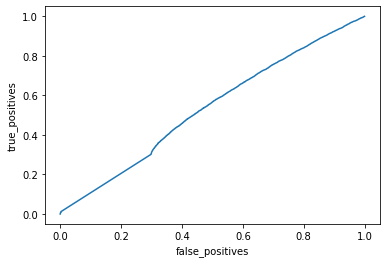

In [17]:
plt.plot(fpr, tpr)
plt.xlabel('false_positives')
plt.ylabel('true_positives')
plt.show()

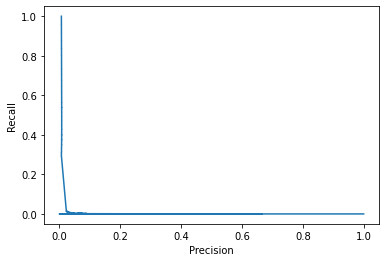

In [18]:
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

In [19]:
recall_score(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
            torch.sigmoid(torch.tensor(results.t_out.cp_logits.flatten()).float())>0.455, zero_division=1)

0.29659419379163

In [20]:
precision_score(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
            torch.sigmoid(torch.tensor(results.t_out.cp_logits.flatten()).float())>0.455, zero_division=0)

0.006949536354025872

In [21]:
thresholds[-15]

0.49938124

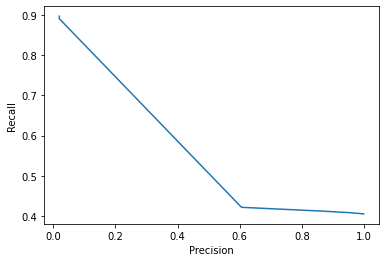

In [22]:
plt.plot(df_nn['Precision'], df_nn['Recall'])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

In [23]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1)
df_grad

Finished 'prMetricsByThresh' in 7.3549 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007360,1.000000,0.036458,0.030035,0.515017,0.00,0.014612
1,0.401342,0.819978,0.981255,0.983203,0.901591,0.05,0.538912
2,0.722469,0.747005,0.992415,0.995300,0.871153,0.10,0.734533
3,0.835708,0.698908,0.994481,0.997968,0.848438,0.15,0.761210
4,0.892308,0.662023,0.994971,0.998911,0.830467,0.20,0.760106
5,0.928999,0.629732,0.995072,0.999383,0.814557,0.25,0.750637
6,0.951078,0.599684,0.994976,0.999620,0.799652,0.30,0.735569
7,0.965252,0.579236,0.994889,0.999758,0.789497,0.35,0.724005
8,0.973411,0.556852,0.994721,0.999841,0.778347,0.40,0.708435
9,0.981822,0.538727,0.994568,0.999900,0.769313,0.45,0.695714


In [24]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5)
df_var

Finished 'prMetricsByThresh' in 6.2755 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007335,1.000000,0.033319,0.026874,0.513437,0.000,0.014563
1,0.611856,0.524180,0.975489,0.980716,0.752448,0.025,0.564635
2,0.822666,0.448210,0.988645,0.994936,0.721573,0.050,0.580272
3,0.912341,0.430061,0.991087,0.997628,0.713845,0.075,0.584568
4,0.939745,0.422397,0.991849,0.998490,0.710444,0.100,0.582825
5,0.952345,0.416802,0.992211,0.998916,0.707859,0.125,0.579834
6,0.961141,0.414391,0.992472,0.999210,0.706800,0.150,0.579104
7,0.967481,0.413185,0.992702,0.999461,0.706323,0.175,0.579067
8,0.976307,0.410899,0.992858,0.999644,0.705272,0.200,0.578377
9,0.980999,0.410368,0.992941,0.999737,0.705052,0.225,0.578669


In [25]:
#chm22 genetic map and vcf (vcf is used to get the snp position)
config['data.genetic_map'] = osp.join(os.environ.get('IN_PATH'), 'humans/reference_files/allchrs.b38.gmap')
config['data.vcf_dir'] = osp.join(os.environ.get('IN_PATH'), 'humans/master_vcf_files/ref_final_beagle_phased_1kg_hgdp_sgdp_chr22.vcf.gz')

In [26]:
#get recomb_rate
genetic_map_path = config['data.genetic_map']
vcf_file_path = config['data.vcf_dir']
df_gm_chm22, df_vcf, df_snp_pos = get_recomb_rate(genetic_map_path, vcf_file_path, chm='chr22')
df_snp_pos = interpolate_genetic_pos(df_snp_pos, df_gm_chm22)
recomb_w = form_windows(df_snp_pos, params.chmlen, params.win_size)
recomb_rate = np.diff(recomb_w)

Finished 'get_recomb_rate' in 71.3477 secs
Finished 'interpolate_genetic_pos' in 0.0038 secs
Finished 'form_windows' in 0.0177 secs


In [27]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
pred_cps, predictive_ls, e_mean_ls = [], [] ,[]

batch_size_cpd = data_tensor.shape[0]
# mu_prior = torch.mean(data_tensor, dim =1).float().reshape(batch_size_cpd, 1,n_vec_dim)
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (torch.var(data_tensor, dim =1).float().unsqueeze(1) * \
             torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = 0.01*torch.eye(n_vec_dim).unsqueeze(0).repeat([batch_size_cpd,1,1]).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
print(data_tensor.shape, cov_prior.shape, mu_prior.shape, cov_x.shape)
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(recomb_rate, T, likelihood_model, batch_size_cpd)

posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')
pred_cps.append(model_cpd.cp)
predictive_ls.append(predictive)
e_mean_ls.append(e_mean)

torch.Size([3650, 317, 3]) torch.Size([3650, 1, 3, 3]) torch.Size([3650, 1, 3]) torch.Size([3650, 1, 3, 3])
Finished 'run_recursive' in 210.2481 secs


In [28]:
bocp_rl = model_cpd.cp.detach().numpy()
bocp_rl_diff = bocp_rl[:,1:]-bocp_rl[:,:-1]
bocd_cp = np.zeros((batch_size_cpd, T))
bocd_cp_idx = np.nonzero((bocp_rl_diff<-4))
for i,j in zip(bocd_cp_idx[0], bocd_cp_idx[1]):
    if bocp_rl[i,j+1]<4:
        bocd_cp[i,j]=1

In [29]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20,0,10)
df_bocd

Finished 'prMetricsByThresh' in 24.0461 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,1.000000,0.404384,0.993123,1.000000,0.702192,0.0,0.575888
1,1.000000,0.404384,0.993123,1.000000,0.702192,0.5,0.575888
2,0.796577,0.644719,0.994583,0.998723,0.821721,1.0,0.712648
3,0.796577,0.644719,0.994583,0.998723,0.821721,1.5,0.712648
4,0.646367,0.747832,0.993458,0.996350,0.872091,2.0,0.693407
5,0.646367,0.747832,0.993458,0.996350,0.872091,2.5,0.693407
6,0.571747,0.785241,0.991696,0.994108,0.889674,3.0,0.661699
7,0.571747,0.785241,0.991696,0.994108,0.889674,3.5,0.661699
8,0.524997,0.802608,0.990045,0.992223,0.897415,4.0,0.634777
9,0.524997,0.802608,0.990045,0.992223,0.897415,4.5,0.634777


In [30]:
bocp_rl_diff.shape

(3650, 317)

In [31]:
np.unique(np.nonzero(test_dataset.data['cps'])[:,0]).shape, np.unique(np.nonzero(bocd_cp)[0]).shape

((2174,), (2607,))

In [32]:
np.nonzero(test_dataset.data['cps'][1253,:]), np.nonzero(bocd_cp[1253,:])

(tensor([[199]]), (array([199, 316]),))

In [33]:
eval_cp_matrix(np.nonzero(test_dataset.data['cps'][1253,:].detach().cpu()), np.nonzero(bocd_cp[1253,:])[0], seq_len=317)

(1, 1, 0, 315, array([[  0., 117.]]))

# Qualitative by looking at anecdotes/samples

In [34]:
[cp.name for cp in cpMethod]

['neural_network', 'gradient', 'mc_dropout', 'BOCD']

In [35]:
# index=2500
index = 2900
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
cpThresh=[0.460, 0.1, 0.025, 4]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target.detach().cpu().numpy()
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [36]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(8,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=15)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=15)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[7].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    ax[7].set_title("True Cps")
    plt.show()

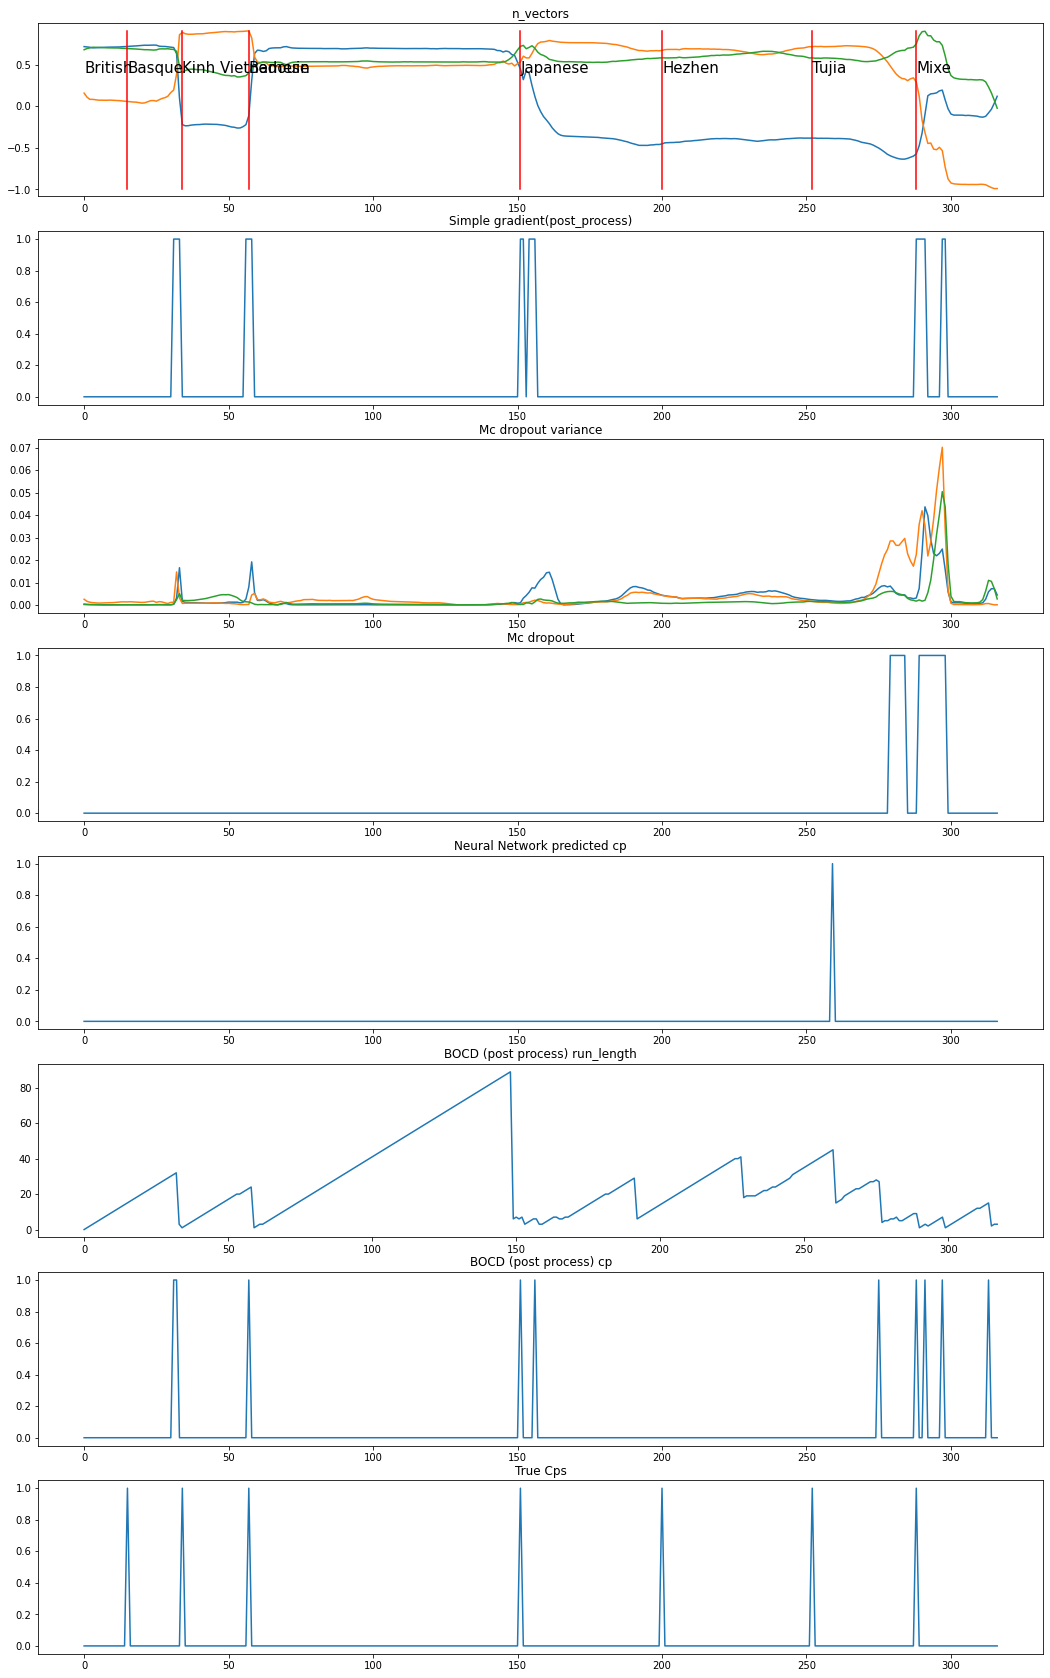

In [37]:
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=bocp_rl[index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

In [38]:
np.nonzero(pred_cps[cpMethod.neural_network.name])

(array([   3,    7,    9, ..., 3646, 3648, 3649]),
 array([243,  48,  36, ...,  92,  10, 244]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [39]:
results.t_out.cp_logits.shape

(3650, 317, 1)

In [40]:
tmp_cpprob = torch.sigmoid(torch.tensor(results.t_out.cp_logits).float())

In [41]:
np.nonzero(true_cpsSample), np.nonzero(pred_cps[cpMethod.BOCD.name][index,:])

((array([ 15,  34,  57, 151, 200, 252, 288]),),
 (array([ 31,  32,  57, 151, 156, 275, 288, 291, 297, 313]),))

In [42]:
np.nonzero(pred_cps[cpMethod.BOCD.name][index,:]), np.nonzero(true_cps[index,:]), np.nonzero(pred_cps[cpMethod.gradient.name][index,:])

((array([ 31,  32,  57, 151, 156, 275, 288, 291, 297, 313]),),
 (array([ 15,  34,  57, 151, 200, 252, 288]),),
 (array([ 31,  32,  33,  56,  57,  58, 151, 152, 154, 155, 156, 288, 289,
         290, 291, 297, 298]),))

In [43]:
bocp_rl_diff_1 = bocp_rl[:,1:] - bocp_rl[:,:-1]
bocd_cp2 = np.zeros((batch_size_cpd, T))
bocd_cp_idx1 = np.nonzero((bocp_rl_diff_1<0))
for i,j in zip(bocd_cp_idx1[0], bocd_cp_idx1[1]):
    if bocp_rl[i,j+1]<3:               
        bocd_cp2[i,j]=1

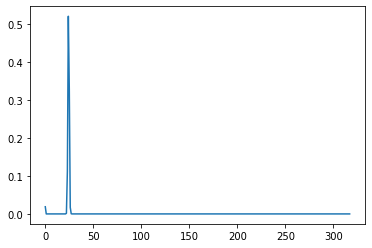

In [44]:
plt.plot(torch.exp(posterior[index,:][:,210]))
plt.show()

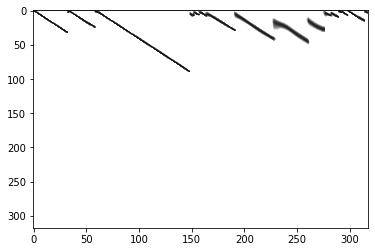

In [45]:
plt.imshow(torch.exp(posterior[index,:]), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
plt.show()

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
                                    pred_cps['gradient'].flatten())

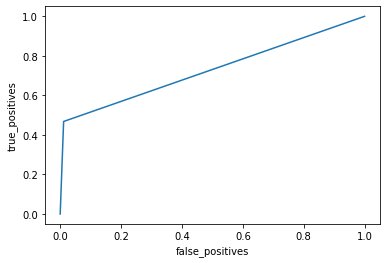

In [47]:
plt.plot(fpr, tpr)
plt.xlabel('false_positives')
plt.ylabel('true_positives')
plt.show()

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
                                    results.t_out.y_var.flatten())
plt.plot(fpr, tpr)
plt.xlabel('false_positives')
plt.ylabel('true_positives')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [1157050, 3471150]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
                                    pred_cps['neural_network'].flatten())
plt.plot(fpr, tpr)
plt.xlabel('false_positives')
plt.ylabel('true_positives')
plt.show()

# evaluate on a subset of samples that have at least 1 changepoint 


In [ ]:
subset_idx=torch.unique(torch.nonzero(test_dataset.data['cps'])[:,0])

In [ ]:
subsetSamples_trueCps=test_dataset.data['cps'][subset_idx,:]
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20, 0.4, 0.5)
df_nn

In [ ]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20, 0,1)
df_grad

In [ ]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var[subset_idx,:]).float(), \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20, 0,0.5)
df_var

In [ ]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp[subset_idx,:], \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20,0,10)
df_bocd

# evaluate all by windows , i.e no win tolerance

In [ ]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5, byWindows=True)
df_nn

In [ ]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1, byWindows=True)
df_grad

In [ ]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5, byWindows=True)
df_var

In [ ]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20,1,10, byWindows=True)
df_bocd

# compute metrics by placing win_tol=0

In [ ]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5, win_tol=0, byWindows=False)
df_nn

In [ ]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1, win_tol=0, byWindows=False)
df_grad

In [ ]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5, win_tol=0, byWindows=False)
df_var

In [ ]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20,1,10, win_tol=2, byWindows=False)
df_bocd

# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [ ]:
subsetSamples_trueCps=test_dataset.data['cps'][subset_idx,:]
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20, 0.4, 0.5, win_tol=0)
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20, 0,1, win_tol=0)
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var[subset_idx,:]).float(), \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20, 0,0.5, win_tol=0)
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp[subset_idx,:], \
                        subsetSamples_trueCps.unsqueeze(2).float(), 20,0,10, win_tol=0)

In [ ]:
df_nn

In [ ]:
df_grad

In [ ]:
df_var

In [ ]:
df_bocd